

### Model train, val, and test
### Feb 2023





In [1]:
!pip install torchvision --upgrade
!pip install grad-cam
!pip install timm
!pip install imagecodecs

!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-n657k98n
  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-n657k98n
  Resolved https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to commit 6b5e8953a80aef5b324104dc0c2e9b8c34d622bd
  Preparing metadata (setup.py) ... done


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision.datasets import VisionDataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
# from warmup_scheduler import GradualWarmupScheduler

import os 
from os import path

import numpy as np
import pandas as pd
from scipy.io import loadmat

from tqdm import tqdm
from PIL import Image

# read tiff
import zipfile
from tifffile import imread
from torchvision.transforms import ToTensor
import random
import csv

import matplotlib.pyplot as plt

from Dataset import train_preprocess, test_preprocess, Keyhole, Keyhole_Test
from utils import initiate_model, cosine_scheduler, train, validation, save_model, save_loss_record

In [3]:
!nvidia-smi

Fri Feb 17 02:03:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   36C    P0    62W / 300W |   5827MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pwd

/home/ec2-user/absorption


In [5]:
train_data_path = "/home/ec2-user/absorption/training_dataset"
test_data_path = "/home/ec2-user/absorption/testing_dataset"

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
num_workers = 2 if cuda else 0
print("Cuda = " + str(cuda)+" with num_workers = "+str(num_workers))

Cuda = True with num_workers = 2


In [6]:
# need to write config file to make this part elegent
batch_size = 32
split_num="5"

train_dataset = Keyhole(train_data_path, transform= train_preprocess, train=True, split=split_num)
val_dataset = Keyhole(train_data_path, transform= test_preprocess, train=False, split=split_num)
test_dataset = Keyhole_Test(test_data_path, transform= test_preprocess)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

len fullset_X 1870
len train_idx 1472
len val_idx 398
len fullset_X 1870
len train_idx 1472
len val_idx 398
['MLCW_P40_nsw_processed_frame001.tif', 'MLCW_P40_nsw_processed_frame002.tif', 'MLCW_P40_nsw_processed_frame003.tif', 'MLCW_P40_nsw_processed_frame004.tif', 'MLCW_P40_nsw_processed_frame005.tif', 'MLCW_P40_nsw_processed_frame006.tif', 'MLCW_P40_nsw_processed_frame007.tif', 'MLCW_P40_nsw_processed_frame008.tif', 'MLCW_P40_nsw_processed_frame009.tif', 'MLCW_P40_nsw_processed_frame010.tif', 'MLCW_P40_nsw_processed_frame011.tif', 'MLCW_P40_nsw_processed_frame012.tif', 'MLCW_P40_nsw_processed_frame013.tif', 'MLCW_P40_nsw_processed_frame014.tif', 'MLCW_P40_nsw_processed_frame015.tif', 'MLCW_P40_nsw_processed_frame016.tif', 'MLCW_P40_nsw_processed_frame017.tif', 'MLCW_P40_nsw_processed_frame018.tif', 'MLCW_P40_nsw_processed_frame019.tif', 'MLCW_P40_nsw_processed_frame020.tif', 'MLCW_P40_nsw_processed_frame021.tif', 'MLCW_P40_nsw_processed_frame022.tif', 'MLCW_P40_nsw_processed_frame023.

len fullset_X 477


## Model training + CAM modification 
https://github.com/jacobgil/pytorch-grad-cam

In [7]:
#del model
pretrain_flag = False
torch.cuda.empty_cache()
model = initiate_model('convnext', pretrained=pretrain_flag)
model.cuda()

/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [8]:
# from torchsummary import summary
# summary(model, (3, 224, 224))

In [9]:
epochs=300
criterion = torch.nn.SmoothL1Loss()
if type(model) == torchvision.models.resnet.ResNet:
    lr = 4e-3
    lr_min = 1e-6
if type(model) == torchvision.models.convnext.ConvNeXt:
    lr = 1e-4
    lr_min = 1e-7

num_training_steps_per_epoch = len(train_dataset) // batch_size
lr_schedule_values = cosine_scheduler(lr, lr_min, 300, num_training_steps_per_epoch, warmup_epochs=20)

optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.05)

scheduler = None

epochs = 300

scaler = torch.cuda.amp.GradScaler()

Set warmup steps = 920


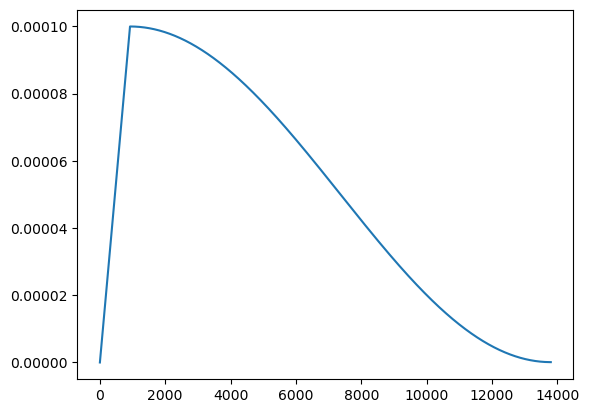

In [10]:
plt.plot(lr_schedule_values)

In [11]:
# train and val, no test yet

train_loss_record = []
val_loss_record = []
for epoch in range(epochs):
  train_loss = train(model, 
                     device, 
                     train_loader, 
                     optimizer, 
                     criterion, 
                     scaler, 
                     num_training_steps_per_epoch,
                     scheduler=None,
                     start_steps=epoch*num_training_steps_per_epoch, 
                     lr_schedule_values=lr_schedule_values)
  print("Epoch {}/{}: Train Loss {:.04f}, lr {:.08f}".format(epoch + 1, epochs, train_loss, optimizer.param_groups[0]['lr']))
  val_loss = validation(model, device, val_loader, optimizer, criterion)
  print("val loss: {:.4f}".format(val_loss))
  train_loss_record.append(train_loss)
  val_loss_record.append(val_loss)
  if epoch == 299:
    ####### Change the name!!! #######
    if pretrain_flag:
        name = "Convnext_pretrain_split" # "Resnet_pretrain_split"
    else:
        name = "Convnext_nopretrain_split"
    save_model(model, epoch, name+split_num, optimizer, scheduler, batch_size)
    save_loss_record(train_loss_record, val_loss_record, name+split_num+"_loss_log.csv")

Epoch 1/300: Train Loss 23.2466, lr 0.00000490
val loss: 23.7940
Epoch 2/300: Train Loss 23.1135, lr 0.00000990
val loss: 23.8157
Epoch 3/300: Train Loss 23.1253, lr 0.00001491
val loss: 23.7987
Epoch 4/300: Train Loss 23.1320, lr 0.00001991
val loss: 23.8219
Epoch 5/300: Train Loss 23.1204, lr 0.00002492
val loss: 23.8121
Epoch 6/300: Train Loss 23.1435, lr 0.00002992
val loss: 23.7978
Epoch 7/300: Train Loss 23.1263, lr 0.00003493
val loss: 23.7940
Epoch 8/300: Train Loss 23.1263, lr 0.00003993
val loss: 23.8055
Epoch 9/300: Train Loss 23.1178, lr 0.00004494
val loss: 23.8786
Epoch 10/300: Train Loss 23.1429, lr 0.00004995
val loss: 23.7933
Epoch 11/300: Train Loss 23.0841, lr 0.00005495
val loss: 23.6022
Epoch 12/300: Train Loss 22.3111, lr 0.00005996
val loss: 21.8550
Epoch 13/300: Train Loss 20.3531, lr 0.00006496
val loss: 19.9148
Epoch 14/300: Train Loss 18.0631, lr 0.00006997
val loss: 18.6565
Epoch 15/300: Train Loss 16.7300, lr 0.00007497
val loss: 17.4764
Epoch 16/300: Train

Epoch 126/300: Train Loss 8.4814, lr 0.00006866
val loss: 8.4132
Epoch 127/300: Train Loss 8.0797, lr 0.00006814
val loss: 8.3170
Epoch 128/300: Train Loss 7.5400, lr 0.00006761
val loss: 8.3362
Epoch 129/300: Train Loss 7.6158, lr 0.00006709
val loss: 8.8087
Epoch 130/300: Train Loss 8.0586, lr 0.00006656
val loss: 8.9566
Epoch 131/300: Train Loss 8.6362, lr 0.00006603
val loss: 8.2889
Epoch 132/300: Train Loss 8.1426, lr 0.00006550
val loss: 8.9582
Epoch 133/300: Train Loss 7.5779, lr 0.00006496
val loss: 7.9751
Epoch 134/300: Train Loss 7.9890, lr 0.00006443
val loss: 8.1619
Epoch 135/300: Train Loss 7.5325, lr 0.00006389
val loss: 8.0959
Epoch 136/300: Train Loss 7.3050, lr 0.00006335
val loss: 7.6699
Epoch 137/300: Train Loss 7.3807, lr 0.00006281
val loss: 7.7989
Epoch 138/300: Train Loss 7.1383, lr 0.00006227
val loss: 8.4507
Epoch 139/300: Train Loss 7.9705, lr 0.00006172
val loss: 7.8079
Epoch 140/300: Train Loss 7.3626, lr 0.00006118
val loss: 8.0483
Epoch 141/300: Train Loss

val loss: 4.8681
Epoch 253/300: Train Loss 4.9914, lr 0.00000689
val loss: 4.7725
Epoch 254/300: Train Loss 4.7246, lr 0.00000661
val loss: 5.0358
Epoch 255/300: Train Loss 4.9781, lr 0.00000634
val loss: 4.9753
Epoch 256/300: Train Loss 4.5352, lr 0.00000607
val loss: 5.2856
Epoch 257/300: Train Loss 4.8667, lr 0.00000581
val loss: 4.7660
Epoch 258/300: Train Loss 4.6418, lr 0.00000555
val loss: 4.6737
Epoch 259/300: Train Loss 4.5558, lr 0.00000530
val loss: 5.0044
Epoch 260/300: Train Loss 4.7926, lr 0.00000505
val loss: 4.9820
Epoch 261/300: Train Loss 4.6677, lr 0.00000481
val loss: 4.8030
Epoch 262/300: Train Loss 4.3751, lr 0.00000458
val loss: 4.8235
Epoch 263/300: Train Loss 4.3149, lr 0.00000435
val loss: 4.7594
Epoch 264/300: Train Loss 4.7243, lr 0.00000412
val loss: 4.8978
Epoch 265/300: Train Loss 4.7143, lr 0.00000391
val loss: 4.9001
Epoch 266/300: Train Loss 4.8778, lr 0.00000370
val loss: 4.7865
Epoch 267/300: Train Loss 4.7963, lr 0.00000349
val loss: 4.8061
Epoch 26

In [ ]:
name

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_record)
plt.plot(val_loss_record)

In [ ]:
def save_model(model, epoch, model_name, optimizer, scheduler, batch_size):
    torch.save({  
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        # 'scheduler_state_dict' : scheduler.state_dict() if scheduler is not None,
                        'batch_size': batch_size,
                        'lr': optimizer.param_groups[0]['lr'],
            }, model_name + '_epoch_' + str(epoch+1))

In [ ]:
save_model(model, epoch, "Resnet_nopretrain_split1", optimizer, scheduler, batch_size)
save_loss_record(train_loss_record, val_loss_record, "Resnet_nopretrain_split1_loss_log.csv")

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_record)
plt.plot(val_loss_record)

In [ ]:
checkpoint = torch.load("ResNet50_nopretrain_epoch_300")
model.load_state_dict(checkpoint['model_state_dict'])